# How to Open/Read a CDF File

This document should serve to cover the basics of how to open and read data saved in the cdf format.
This will assume you have the following packages installed in your python environment:
- cdflib
- spacepy
- matplotlib
- numpy
- wget


## What is a CDF file?

The Common Data Format (CDF), this is a format that has been championed by NASA recently. It is very common for more recent data recorded by in situ measurements as well as reprocessed data from older missions. More information on CDF and tools can be found here:
https://cdf.gsfc.nasa.gov/

The CDF allows for a more flexible storage of data variables that may or may not have different lengths. For example, if you had temperature measurements at several points in space recorded at certain times, a standard way to store this information in an ascii table would be like so:
    <img src="basicDataTable.jpg">
As you can see, this relies on repeated measurement values to properly show each unique combination taking up a record number. A cdf file uses pointers within the file connecting higher-dimension arrays (zVariables) to each other and to each record number:
    <img src="cdfDataTable.jpg">
This allows us to be much more flexible with the way we concatenate data as well as cuts down on storage space. It also is necessary in order to coherently store higher-order arrays.

Instructions (extremely detailed) on CDF can be found here: https://spdf.gsfc.nasa.gov/pub/software/cdf/doc/cdf380/cdf380ug.pdf

## Install CDF library

CDF library version 3.8 can be downloaded here: https://spdf.gsfc.nasa.gov/pub/software/cdf/dist/cdf38_0/ 

For Windows, it is suggested you use the InstallMate installer to automatically set paths. For MacOS, the universal installer is probably easiest.


## Install python packages to read CDF

The two python packages we will use here to read CDF files are the [pycdf](https://spacepy.github.io/pycdf.html) package found within the spacepy toolset, and [cdflib](https://github.com/MAVENSDC/cdflib). These can be installed easily using pip, and possible conda (depending on your version of python). Depending on how you have your environment set up, it should be as simple as:
```
pip install cdflib
pip install spacepy
```

## Download a cdf

For the purposes of this demonstration, we will start with a cdf from the Parker Solar Probe FIELDS team. The release notes and information about the data can be found here:
https://fields.ssl.berkeley.edu/data/
We will first look at the 1-minute downsampled DC magnetic field measurements in RTN coordinates. This is a useful data product for analyzing the survey-level observations of large scale structures and polarity reversals. The RTN coordinate system is helpful to remove any anomalous signals due to spacecraft maneuvers or motion, and is described relative to other popular coordinate systmes here:
http://www.srl.caltech.edu/ACE/ASC/coordinate_systems.html
For a more in-depth explanation at how to transform between coordinate systems (particulary geocentric orientations) see this article by Hapgood:
https://www.sciencedirect.com/science/article/pii/003206339290012D

The FIELDS Level-2 data archive can be found here:
https://research.ssl.berkeley.edu/data/psp/data/sci/fields/l2/

For this demonstration, we will choose a datafile from Encounter 2, on 2019-04-01. The most basic way to access the file we are interested is to navigate to the relevant folder with any web browser and manually download the file to your local directory. The highest-version available is located at this address:
https://research.ssl.berkeley.edu/data/psp/data/sci/fields/l2/mag_RTN_1min/2019/04/psp_fld_l2_mag_RTN_1min_20190401_v02.cdf

Optionally, we can use wget to download the file. This is particularly helpful for when we want to pull multiple files at a time or switch between different timeranges of interest without having to change our code in multiple places.

Below, we outline a script that downloads the relevant file with wget after checking to see if the file is already present in the local folder.

In [3]:
import wget
import os

year  = '2019'
month = '04'
day   = '01'

# By using "fstrings" we can easily substitute variables into the filename
remoteDirectory = f'https://research.ssl.berkeley.edu/data/psp/data/sci/fields/l2/mag_RTN_1min/{year}/{month}/'
remoteFilename = f'psp_fld_l2_mag_RTN_1min_{year}{month}{day}_v02.cdf'

if os.path.isfile(remoteFilename):
    print ("File exists already")
    magRTN_file = remoteFilename
else:
    print ("File doesn't exist, downloading")
    magRTN_file = wget.download(remoteDirectory + remoteFilename)

File doesn't exist, downloading
100% [..............................................................................] 94347 / 94347

## Open a cdf file

First, we will examine the properties of this file with pycdf. You are encouraged to look into the full pycdf documentation to get an idea of other capabilities, as we will only look at reading in data here.

We will start by printing out the list of variables in the file. You will notice each variable will identify the type of value it contains (real numbers, integers, strings, etc.) as well as the size of the array in square brackets. There is no limit to the dimensionality of these arrays, although typically the most complicated arrays in space science will have up to 4 dimensions of data.

Next we will look at the global metadata record within the file. This record can contain a range of valuable information including the version number and date, release notes location, calibration files used, and relevant publications.

In [25]:
from spacepy import pycdf
cdf_magRTN_pycdf = pycdf.CDF(magRTN_file)

print('These are the variables within this file:\n')
print(cdf_magRTN_pycdf)

print('\n\n-------------------------------------\n\n')
print('This is the global metadata record of the file:\n')
print(cdf_magRTN_pycdf.attrs)

These are the variables within this file:

component_index_RTN: CDF_INT4 [3] NRV
epoch_mag_RTN_1min: CDF_TIME_TT2000 [1440]
epoch_quality_flags: CDF_TIME_TT2000 [1440]
label_RTN: CDF_CHAR*3 [3] NRV
psp_fld_l2_mag_RTN_1min: CDF_REAL4 [1440, 3]
psp_fld_l2_quality_flags: CDF_UINT4 [1440]


-------------------------------------


These is the global metadata record of the file:

Acknowledgement: 
Data_type: L2>Level 2 Data [CDF_CHAR]
Data_version: 02 [CDF_CHAR]
Dependencies: None [CDF_CHAR]
Descriptor: MAG_RTN_1min>Fluxgate Magnetometer data in RTN coordinates [CDF_CHAR]
Discipline: Solar Physics>Heliospheric Physics [CDF_CHAR]
            Space Physics>Interplanetary Studies [CDF_CHAR]
File_naming_convention: source_datatype_descriptor_yyyyMMdd [CDF_CHAR]
Generated_by: PSP FIELDS SOC [CDF_CHAR]
Generation_date: Wed Jun 23 23:31:53 2021 [CDF_CHAR]
HTTP_LINK: http://fields.ssl.berkeley.edu/data/ [CDF_CHAR]
Instrument_type: Magnetic Fields (space) [CDF_CHAR]
LINK_TEXT: PSP/FIELDS SOC [CDF_CH

Now, we will perform the same operations with cdflib. The formatting is not as human-readable as the output for pycdf, but may be simpler to parse with a text crawler. A large benefit of cdflib is that the cdf library is built in, so that the installation step above is not required. More information/documentation on cdflib can be found here:
https://pypi.org/project/cdflib/

In [43]:
import cdflib
cdf_magRTN_cdflib = cdflib.CDF(magRTN_file)

print('These are the variables within this file:\n')
print(cdf_magRTN_cdflib._get_varnames())

print('\n\n-------------------------------------\n\n')
print('These is the global metadata record of the file:\n')
print(cdf_magRTN_cdflib.globalattsget())

These are the variables within this file:

([], ['epoch_mag_RTN_1min', 'psp_fld_l2_mag_RTN_1min', 'label_RTN', 'component_index_RTN', 'epoch_quality_flags', 'psp_fld_l2_quality_flags'])


-------------------------------------


These is the global metadata record of the file:

{'TITLE': 'PSP FIELDS Fluxgate Magnetometer (MAG) data', 'Project': 'PSP', 'Discipline': ['Solar Physics>Heliospheric Physics', 'Space Physics>Interplanetary Studies'], 'Source_name': 'PSP_FLD>Parker Solar Probe FIELDS', 'Descriptor': 'MAG_RTN_1min>Fluxgate Magnetometer data in RTN coordinates', 'Data_type': 'L2>Level 2 Data', 'Data_version': '02', 'TEXT': ['PSP FIELDS Fluxgate Magnetometer data. Time resolution varies with instrument mode, ranging from 2.3-292.9 samples/sec, corresponding to 2-256 samples per 0.874 seconds (0.874 = 2^25 / 38.4 MHz, see reference [2]).', 'The Magnetometer has 4 ranges - +/-1024, +/-4096, +/-16,384, +/-65,536 nT, selected by the ranging algorithm, based on the ambient magnetic fie

For the purposes of this tutorial, we will focus more heavily on the pycdf pakcage due to its readability, but either package will likely be able to read the same datafiles.

## Examine attributes

Now that we have a list of the variables within this file, we want to look at the attributes of the data variables themselves to find their dependencies and other information. We have already read the entirety of the file into memory, so now will just create a variable out of one of the arryas. 

The array we are most likely to be interested in is, of course, 'psp_fld_l2_mag_RTN_1min'. Our earlier list of the included arrays identified this as:
'''
psp_fld_l2_mag_RTN_1min: CDF_REAL4 [1440, 3]
'''
This indicates that the array is 1440 records long in the 0th dimension by 3 records long in the 1st dimension. The depend_0 (0th dimension dependency) is typically the time record for in situ data products. Since the magnetic field is a vector product, we then have 3 measurements at each point in time corresponding to the field strength in each of the R, T, and N directions.

We will now look at the attributes of this variable, and see how we can automatically incorporate these attributes in our code.


In [50]:
mag_RTN_1min = cdf_magRTN_pycdf['psp_fld_l2_mag_RTN_1min']

print('The attributes of \'psp_fld_l2_mag_RTN_1min\' are:\n')
print(mag_RTN_1min.attrs)

print('\n\nThe timestamps for each of the records in \'psp_fld_l2_mag_RTN_1min\' are found in', mag_RTN_1min.attrs['DEPEND_0'])
print('The range of valid measurements should not fall below', mag_RTN_1min.attrs['VALIDMIN'][0], mag_RTN_1min.attrs['UNITS'], 'or exceed', mag_RTN_1min.attrs['VALIDMAX'][0], mag_RTN_1min.attrs['UNITS'])

The attributes of 'psp_fld_l2_mag_RTN_1min' are:

CATDESC: Magnetic field in RTN coordinates (1 minute cadence) [CDF_CHAR]
DEPEND_0: epoch_mag_RTN_1min [CDF_CHAR]
DEPEND_1: component_index_RTN [CDF_CHAR]
DISPLAY_TYPE: time_series [CDF_CHAR]
FIELDNAM: MAG B_RTN [CDF_CHAR]
FILLVAL: -1e+31 [CDF_REAL4]
FORMAT: E12.2 [CDF_CHAR]
LABLAXIS: B_RTN [CDF_CHAR]
LABL_PTR_1: label_RTN [CDF_CHAR]
SCALETYP: linear [CDF_CHAR]
SI_conv: 1.0e-9>Tesla [CDF_CHAR]
UNITS: nT [CDF_CHAR]
VALIDMAX: [65536. 65536. 65536.] [CDF_REAL4]
VALIDMIN: [-65536. -65536. -65536.] [CDF_REAL4]
VAR_TYPE: data [CDF_CHAR]


The timestamps for each of the records in 'psp_fld_l2_mag_RTN_1min' are found in epoch_mag_RTN_1min
The range of valid measurements should not fall below -65536.0 nT or exceed 65536.0 nT


## Plot data

Now we will generate a simple plot of this dataset using the included metadata to automatically populate our axes. We will first pull the relevant depend_0 values and will use the spacepy 'applySmartTimeTicks()' function to make the x-axis a little more legible than the default plot.

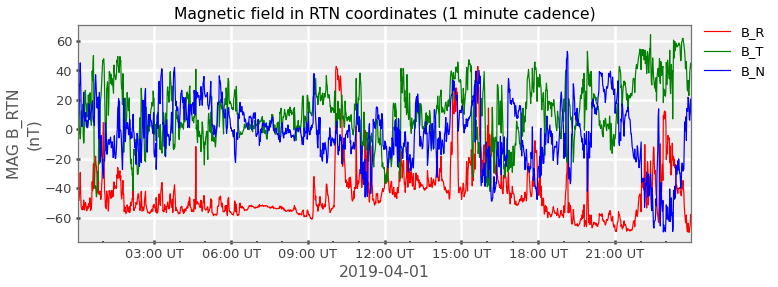

In [100]:
# The spacepy plotter has not been updated with the most recent numpy deprecations, we will ignore the warnings here.
import warnings
warnings.filterwarnings("ignore")

import spacepy.plot as splot
from matplotlib import pyplot as plt
from cycler import cycler

mag_RTN_Units = mag_RTN_1min.attrs['UNITS']
mag_RTN_Label = mag_RTN_1min.attrs['FIELDNAM']
mag_RTN_Title = mag_RTN_1min.attrs['CATDESC']
mag_RTN_1min.attrs['UNITS']
epoch         = cdf_magRTN_pycdf[mag_RTN_1min.attrs['DEPEND_0']]

# Uncomment the line below to look at the attributes of the epoch variable
#print(mag_RTN_time.attrs)

# This line will reset the color order from the default. 
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b'])))

# We create the plot canvas (fig) and subplot (ax) then plot the data within this subplot
fig, ax = splot.plt.subplots()
fig.set_size_inches(11,4)
ax.plot(epoch, mag_RTN_1min, '-')

# We change the time ticks to be more legible and add lables/legend:
splot.applySmartTimeTicks(ax, epoch, dolimit=True, dolabel=False)
ax.set_ylabel(f'{mag_RTN_Label}\n({mag_RTN_Units})')
ax.set_xlabel(f'{epoch[0]}'[0:10])
ax.set_title(mag_RTN_Title)
ax.legend(['B_R', 'B_T', 'B_N'], loc='upper right', bbox_to_anchor=(1.14, 1.05));


## Subset of data

Rather than an entire day's worth of data, we may only be interested in a small subsection. We can use the bisect() function which uses datetime() objects to identify closest data points in the epoch record.

We will use the same file from before, but now we will look at one of the switchback events in more detail.

start of time period: 2019-04-01 09:40:00
end of time period: 2019-04-01 10:50:00
startIndex: 580
stopIndex: 650


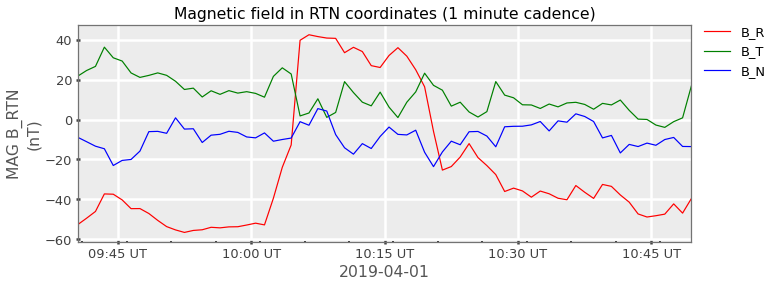

In [105]:
import datetime
# datetime(YYYY, mm, dd, HH, MM)
start = datetime.datetime(2019, 4, 1, 9, 40)
stop  = datetime.datetime(2019, 4, 1, 10, 50)
print('start of time period:',start)
print('end of time period:',stop)
import bisect
startIndex = bisect.bisect_left(epoch, start)
stopIndex  = bisect.bisect_left(epoch, stop)
print('startIndex:',startIndex)
print('stopIndex:',stopIndex)

# We create the plot canvas (fig) and subplot (ax) then plot the data within this subplot
fig, ax = splot.plt.subplots()
fig.set_size_inches(11,4)
ax.plot(epoch[startIndex:stopIndex], mag_RTN_1min[startIndex:stopIndex], '-')

# We change the time ticks to be more legible and add lables/legend:
splot.applySmartTimeTicks(ax, epoch[startIndex:stopIndex], dolimit=True, dolabel=False)
ax.set_ylabel(f'{mag_RTN_Label}\n({mag_RTN_Units})')
ax.set_xlabel(f'{epoch[0]}'[0:10])
ax.set_title(mag_RTN_Title)
ax.legend(['B_R', 'B_T', 'B_N'], loc='upper right', bbox_to_anchor=(1.14, 1.05));

## Append multiple days and then subset from there

Similarly, we can also look at a longer period of time. We can append multiple datasets such that we can plot several files as a single array.

For this portion, we will acquire the files from the following days to look at the evolution of the field measurements around encounter.

In [111]:
import numpy as np

# Now for multiple files from that month
years = ['2019']
months = ['04']
days = ['01','02','03','04','05','06','07']

firstTime = True
for year in years:
    for month in months:
        for day in days:

            # By using "fstrings" we can easily substitute variables into the filename
            remoteDirectory = f'https://research.ssl.berkeley.edu/data/psp/data/sci/fields/l2/mag_RTN_1min/{year}/{month}/'
            remoteFilename = f'psp_fld_l2_mag_RTN_1min_{year}{month}{day}_v02.cdf'

            if os.path.isfile(remoteFilename):
                print ("File exists already")
                magRTN_file = remoteFilename
            else:
                print ("File doesn't exist, downloading")
                magRTN_file = wget.download(remoteDirectory + remoteFilename)
                
            cdf_magRTN = pycdf.CDF(magRTN_file)
            if firstTime==True:
                mag_RTN_1min = cdf_magRTN['psp_fld_l2_mag_RTN_1min']
                firstTime = False
            elif firstTime==False:
                mag_RTN_1min = np.concatenate(mag_RTN_1min, cdf_magRTN['psp_fld_l2_mag_RTN_1min'], axis=0)


File exists already
File doesn't exist, downloading
100% [..............................................................................] 94264 / 94264

TypeError: concatenate() got multiple values for argument 'axis'